In [2]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

#from __future__ import print_function
np.random.seed(1337)  # for reproducibility

#keras - za neuronsku mrezu
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils, generic_utils

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [160]:
#Pomocne funkcije(sa vezbi)
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=2)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=2)
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(16,16), interpolation = cv2.INTER_CUBIC)
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        #if area > 100 and h < 100 and h > 5 and w > 15:
        #if area > 20 and area < 20000 and h < 150 and h > 25 and w > 10 and w<150:
        if area > 80 and area < 25000 and h < 300 and h > 2 and w > 5 and w<300:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            #region = image_bin[y-30:y+h+31,x-30:x+w+31];
            #region = image_bin[y-20:y+h+23,x-20:x+w+23]
            region = image_bin[y:y+h+1,x:x+w+1]
            region = resize_region(region)      
            region_sa_okvirom = np.zeros((28,28), dtype=int)
            region_sa_okvirom[6:22,6:22] = region
            regions_dic[x] = region_sa_okvirom
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
            
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [4]:
#import obucavajuceg skupa - MNIST

batch_size = 128
nb_classes = 14
nb_epoch = 30

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#X_train.append(sign[0])
#y_train.append("+")

#ny_train = np.concatenate((y_train,plu), axis = 1)



Temp_X_train = X_train
Temp_X_test = X_test

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

for i,el in enumerate(X_train):
    for j,pix in enumerate(el):
        if pix > 0.5:
            el[j] = 1
        else: 
            el[j] = 0
        
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print y_train[0], Y_train[0], X_test.shape

60000 train samples
10000 test samples
5 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.] (10000L, 784L)


In [323]:
ny_train = np.concatenate((y_train,plu))
print ny_train.shape

(60010L,)


In [34]:
#funkcije za kreiranje i treniranje NM

def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    model = Sequential()
    #model.add(Dense(512, input_dim=784, activation='sigmoid'))
    #model.add(Dense(11, activation='sigmoid'))
    model.add(Dense(128, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(14))
    model.add(Activation('softmax'))
    return model
    
def train_ann(ann, X_training, y_training):
    '''Obucavanje vestacke neuronske mreze'''
    X_training = np.array(X_training, np.float32) # dati ulazi
    y_training = np.array(y_training, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    #sgd = SGD(lr=0.01, momentum=0.9)
    #ann.compile(loss='mean_squared_error', optimizer=sgd)

    ##rms = RMSprop()
    ##ann.compile(loss='mean_squared_error', optimizer=rms)
    
    # obucavanje neuronske mreze
    #ann.fit(X_train, y_train, nb_epoch=20, batch_size=128, verbose = 2,show_accuracy=True) 
    
    rms = RMSprop()
    ann.compile(loss='categorical_crossentropy', optimizer=rms)
    #ann.fit(X_train, y_train, nb_epoch=20, batch_size=128, verbose = 2,show_accuracy=True) 
    ann.fit(X_training, y_training, 
          batch_size=batch_size, nb_epoch=30,
          show_accuracy=True, verbose=2)
    #score = ann.evaluate(X_test, Y_test,
    #                       show_accuracy=True, verbose=0)
    #validation_data=(X_test, Y_test)
    return ann



In [35]:
#kreiranje i treniranje NM
print konkateniranXP.shape, konkateniranYP.shape
#print noviXtrain.shape, noviYtrain.shape
print X_train.shape, Y_train.shape
ann = create_ann()
ann = train_ann(ann,konkateniranXP,konkateniranYP)

(60040L, 784L) (60040L, 14L)
(60000L, 784L) (60000L, 14L)
Epoch 1/30
7s - loss: 0.4128 - acc: 0.8779
Epoch 2/30
7s - loss: 0.1817 - acc: 0.9452
Epoch 3/30
7s - loss: 0.1376 - acc: 0.9583
Epoch 4/30
8s - loss: 0.1106 - acc: 0.9666
Epoch 5/30
7s - loss: 0.0935 - acc: 0.9712
Epoch 6/30
7s - loss: 0.0818 - acc: 0.9737
Epoch 7/30
8s - loss: 0.0731 - acc: 0.9769
Epoch 8/30
7s - loss: 0.0652 - acc: 0.9793
Epoch 9/30
8s - loss: 0.0583 - acc: 0.9818
Epoch 10/30
8s - loss: 0.0528 - acc: 0.9831
Epoch 11/30
7s - loss: 0.0497 - acc: 0.9837
Epoch 12/30
7s - loss: 0.0448 - acc: 0.9842
Epoch 13/30
7s - loss: 0.0409 - acc: 0.9871
Epoch 14/30
7s - loss: 0.0380 - acc: 0.9873
Epoch 15/30
7s - loss: 0.0369 - acc: 0.9876
Epoch 16/30
7s - loss: 0.0338 - acc: 0.9891
Epoch 17/30
7s - loss: 0.0321 - acc: 0.9897
Epoch 18/30
8s - loss: 0.0291 - acc: 0.9901
Epoch 19/30
7s - loss: 0.0284 - acc: 0.9906
Epoch 20/30
7s - loss: 0.0264 - acc: 0.9909
Epoch 21/30
7s - loss: 0.0236 - acc: 0.9920
Epoch 22/30
7s - loss: 0.02

In [207]:
#Izracunavanje rezultata
rezultat = ann.predict(np.array(numbers,np.float32))
#print numbers[0]

(784L,)


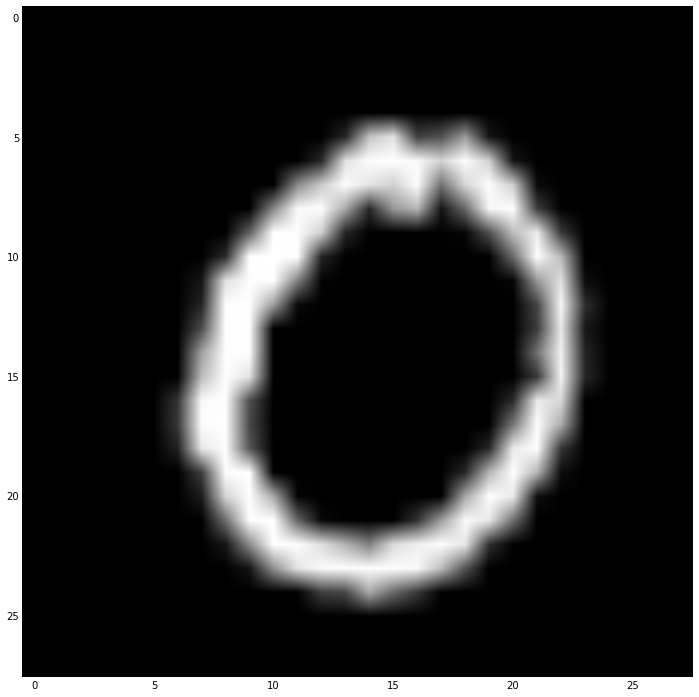

In [42]:
#print rezultat[0]
temp_X_test = Temp_X_test[100:120]
display_image(temp_X_test[1])
print X_train[1].shape

In [39]:
alphabet = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

In [216]:
rezultat = ann.predict(np.array(numbers,np.float32))
print rezultat[1]
my_display_result(rezultat,alphabet)

[  1.73063735e-05   2.15250264e-01   4.77635588e-04   3.09639155e-02
   9.04950582e-02   1.16189098e-03   3.23142836e-04   1.27993843e-02
   1.33712358e-03   9.11186368e-04   6.22723167e-01   1.29526773e-02
   5.73960621e-03   4.84764176e-03]


9

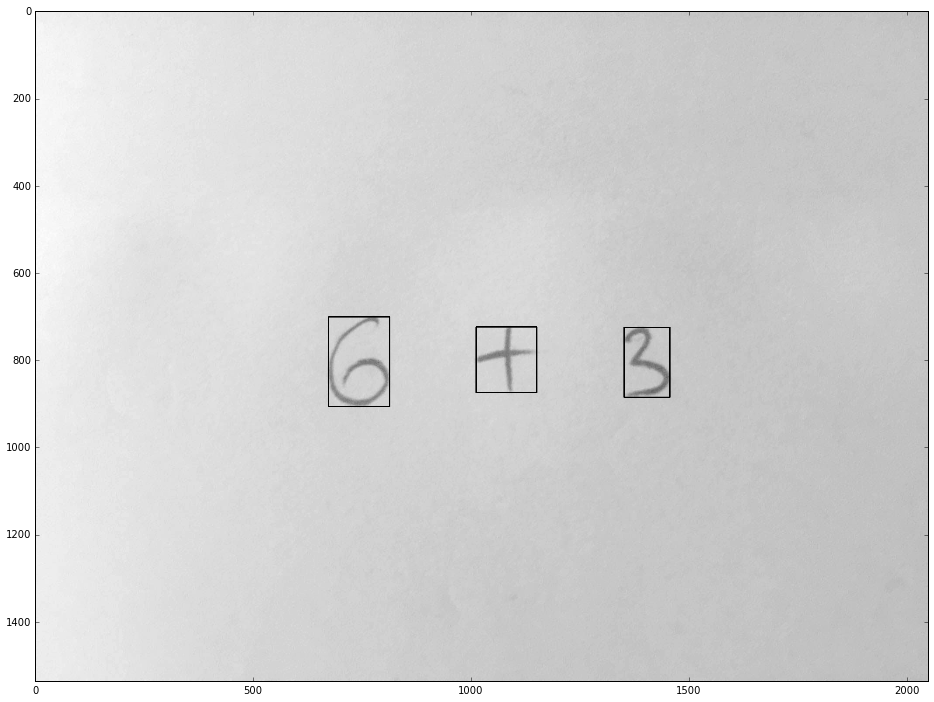

In [214]:
#Ucitavanje slike(slika nije iz MNIST-ovih testnih primera)
image_ada = cv2.imread('test_images/testing/izraz3.jpg')
image_ada = cv2.cvtColor(image_ada, cv2.COLOR_BGR2GRAY)
image_ada_bin = cv2.adaptiveThreshold(image_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 11)
img = invert(image_ada_bin)
img = erode(dilate(img))

selected_regions, numbers = select_roi(image_ada.copy(), img)
display_image(selected_regions)
#display_image(numbers[3])
numbers = prepare_for_ann(numbers)

In [15]:
cap.release()
cv2.destroyAllWindows()

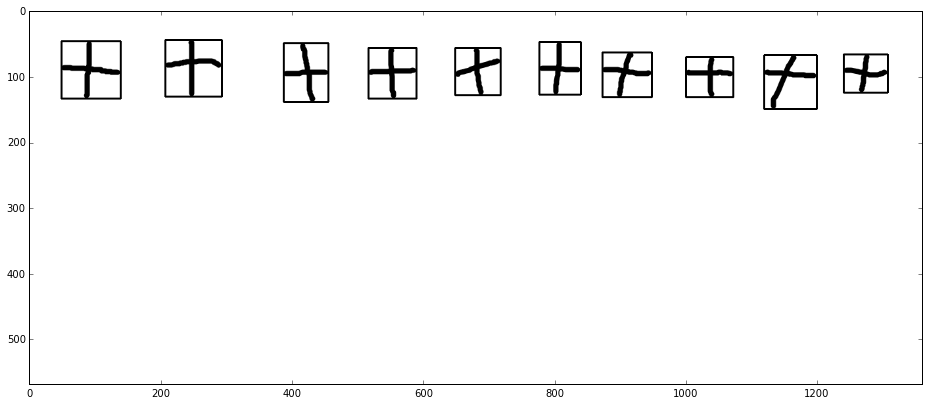

In [6]:
#Plus ucitavanje
mp_ada = cv2.imread('test_images/train_znakovi/plusevi.png')
mp_ada = cv2.cvtColor(mp_ada, cv2.COLOR_BGR2GRAY)
mp_ada_bin = cv2.adaptiveThreshold(mp_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 11)
mp_img = invert(mp_ada_bin)
mp_img = erode(dilate(mp_img))

selected_regions_mp, sign = select_roi(mp_ada.copy(), mp_img)
display_image(selected_regions_mp)
sign = prepare_for_ann(sign)

In [132]:
#Dodavanje plusa u X_train
noviXtrain = np.array(X_train, dtype='float32')
signarray = np.asarray(sign)
print signarray.shape
noviXtrain = np.concatenate((noviXtrain,signarray), axis = 0)
noviXtrain = noviXtrain.reshape(60010,784)
print noviXtrain.shape

(10L, 784L)
(60010L, 784L)


In [133]:
#Dodavanje plusa u Y_train
plusevi_array = []
plus = np.asarray([0,0,0,0,0,0,0,0,0,0,1,0,0,0]);
for i in range(0,10):
    plusevi_array.append(plus)
plusevi_array = np.array(plusevi_array,dtype=float)
#plusevi_array = np.asarray([11,11,11,11,11,11,11,11,11,11])
print plusevi_array.shape
noviYtrain = np.array(Y_train, dtype=float)
noviYtrain = np.concatenate((noviYtrain,plusevi_array), axis = 0)

#noviYtrain = np.ndarray(shape = (60010,11), buffer = noviYtrain)
#noviYtrain, y_test = [np_utils.to_categorical(x) for x in (noviYtrain, y_test)]

noviYtrain = noviYtrain.reshape(60010,14)

print noviYtrain.shape

(10L, 14L)
(60010L, 14L)


In [131]:
#Nebitno
plusevi_array = []
plus = np.asarray([0,0,0,0,0,0,0,0,0,0,1,0,0,0]);
for i in range(0,10):
    plusevi_array.append(plus)
plusevi_array = np.array(plusevi_array,dtype=float)
print plusevi_array.shape


noviXtrain = np.concatenate((X_train,sign),axis = 0)
noviYtrain = np.concatenate((Y_train,plusevi_array), axis = 0)

noviXtrain = noviXtrain.reshape(60010,784)
noviXtrain = noviXtrain.astype('float32')


(10L, 14L)


In [314]:
#Nebitno
pl = np.array(y_train)
plu = [11,11,11,11,11,11,11,11,11,11]
npl = np.concatenate((pl,plu))

nnpl = np.ndarray(shape = (60010,11))

print nnpl.shape

(60010L, 11L)


In [7]:
plusevi_array = []
plus = np.asarray([0,0,0,0,0,0,0,0,0,0,1,0,0,0]);
for i in range(0,10):
    plusevi_array.append(plus)
plusevi_array = np.array(plusevi_array,dtype=float)
#plusevi_array = np.asarray([11,11,11,11,11,11,11,11,11,11])
print plusevi_array.shape

(10L, 14L)


In [8]:
#Another try
konkateniranX = np.concatenate((X_train, np.asarray(sign)), axis = 0)
print konkateniranX.shape

(60010L, 784L)


In [9]:
#Another try
konkateniranY = np.concatenate((Y_train, plusevi_array), axis = 0)
print konkateniranY.shape

(60010L, 14L)


In [13]:
print konkateniranY[60009]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


In [15]:
def select_roi_m(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        #if area > 100 and h < 100 and h > 5 and w > 15:
        if area < 20000 and h < 50 and h > 5 and w > 10 and w<200:
            region = image_bin[y:y+h+1,x:x+w+1]
            region = resize_region(region)      
            region_sa_okvirom = np.zeros((28,28), dtype=int)
            region_sa_okvirom[6:22,6:22] = region
            regions_dic[x] = region_sa_okvirom
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
            
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

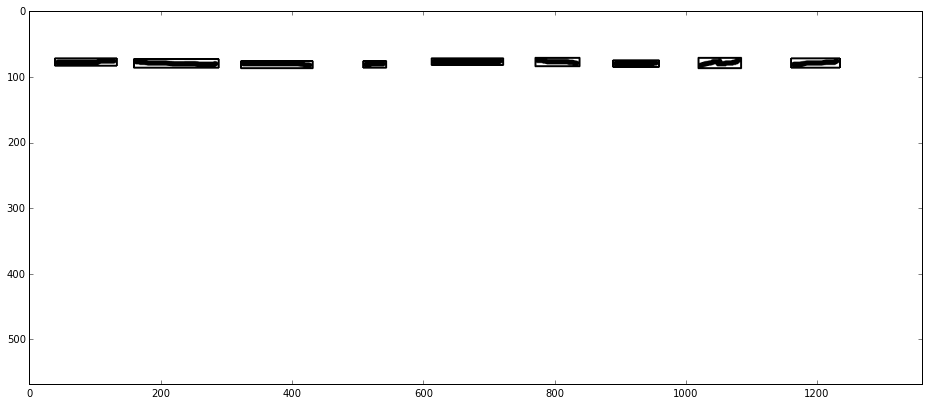

In [16]:
#Minus ucitavanje
mp_ada = cv2.imread('test_images/train_znakovi/minusi.png')
mp_ada = cv2.cvtColor(mp_ada, cv2.COLOR_BGR2GRAY)
mp_ada_bin = cv2.adaptiveThreshold(mp_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 11)
mp_img = invert(mp_ada_bin)
mp_img = erode(dilate(mp_img))

selected_regions_m, minusi = select_roi_m(mp_ada.copy(), mp_img)
display_image(selected_regions_m)
minusi = prepare_for_ann(minusi)

In [17]:
#Another try
minusi_array = []
minus = np.asarray([0,0,0,0,0,0,0,0,0,0,0,1,0,0]);
for i in range(0,9):
    minusi_array.append(minus)
minusi_array = np.array(minusi_array,dtype=float)
print minusi_array.shape

konkateniranXM = np.concatenate((konkateniranX, np.asarray(minusi)), axis = 0)
print konkateniranXM.shape

konkateniranYM = np.concatenate((konkateniranY, minusi_array), axis = 0)
print konkateniranYM.shape

(9L, 14L)
(60019L, 784L)
(60019L, 14L)


In [26]:
print konkateniranYM[60005]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


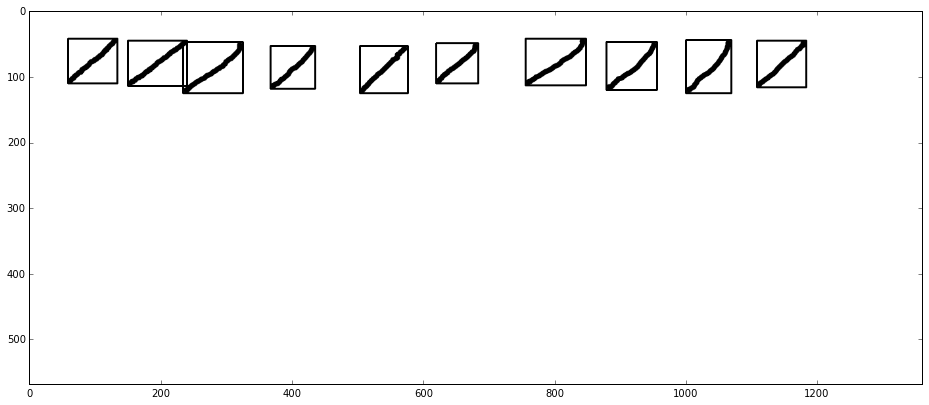

In [27]:
mp_ada = cv2.imread('test_images/train_znakovi/podeljeno.png')
mp_ada = cv2.cvtColor(mp_ada, cv2.COLOR_BGR2GRAY)
mp_ada_bin = cv2.adaptiveThreshold(mp_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 11)
mp_img = invert(mp_ada_bin)
mp_img = erode(dilate(mp_img))

selected_regions_p, podeljeno = select_roi(mp_ada.copy(), mp_img)
display_image(selected_regions_p)
podeljeno = prepare_for_ann(podeljeno)

In [28]:
#Another try
podeljeno_array = []
podeljen = np.asarray([0,0,0,0,0,0,0,0,0,0,0,0,1,0]);
for i in range(0,10):
    podeljeno_array.append(podeljen)
podeljeno_array = np.array(podeljeno_array,dtype=float)
print podeljeno_array.shape

konkateniranXD = np.concatenate((konkateniranXM, np.asarray(podeljeno)), axis = 0)
print konkateniranXD.shape

konkateniranYD = np.concatenate((konkateniranYM, podeljeno_array), axis = 0)
print konkateniranYD.shape

(10L, 14L)
(60029L, 784L)
(60029L, 14L)


In [30]:
print konkateniranYD[60025]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [22]:
konkateniranYD = np_utils.to_categorical(konkateniranYD,14)

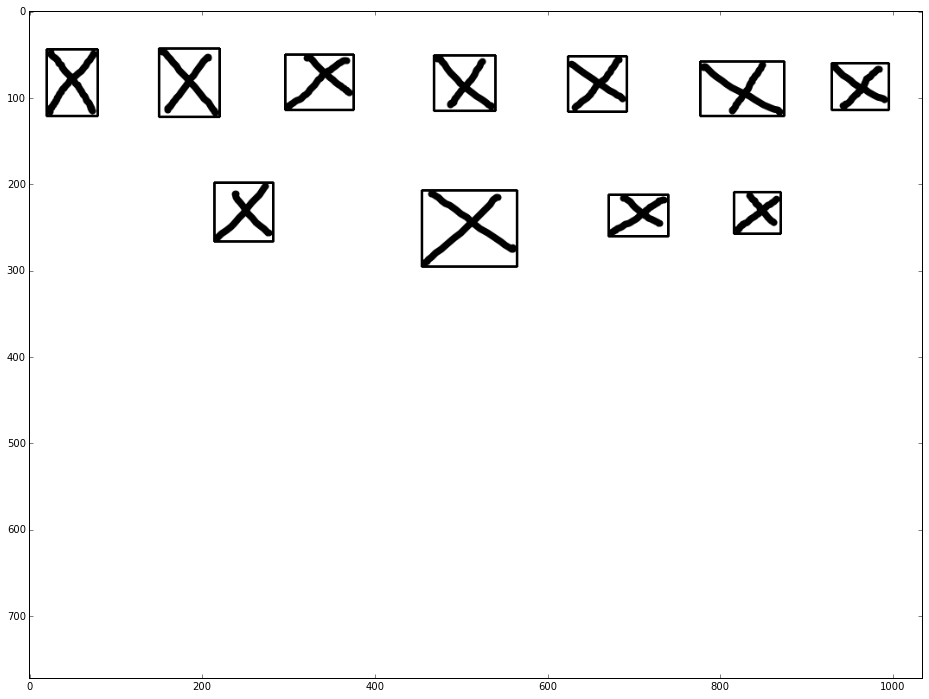

In [31]:
mp_ada = cv2.imread('test_images/train_znakovi/puta_x.png')
mp_ada = cv2.cvtColor(mp_ada, cv2.COLOR_BGR2GRAY)
mp_ada_bin = cv2.adaptiveThreshold(mp_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 11)
mp_img = invert(mp_ada_bin)
mp_img = erode(dilate(mp_img))

selected_regions_pu, puta = select_roi(mp_ada.copy(), mp_img)
display_image(selected_regions_pu)
puta = prepare_for_ann(puta)

In [32]:
#Another try
puta_array = []
puta_x = np.asarray([0,0,0,0,0,0,0,0,0,0,0,0,0,1]);
for i in range(0,11):
    puta_array.append(puta_x)
puta_array = np.array(puta_array,dtype=float)
print puta_array.shape

konkateniranXP = np.concatenate((konkateniranXD, np.asarray(puta)), axis = 0)
print konkateniranXP.shape

konkateniranYP = np.concatenate((konkateniranYD, puta_array), axis = 0)
print konkateniranYP.shape

(11L, 14L)
(60040L, 784L)
(60040L, 14L)


In [120]:
konkateniranYP = np_utils.to_categorical(konkateniranYP,14)

In [130]:
print konkateniranXP.shape, konkateniranYP[60005]

(60040L, 784L) [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [33]:
print konkateniranYP[60005]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


In [213]:
def my_display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    
    new_result = 0;
    
    for i in range(0, len(result)):
        if result[i] == 13:
            new_result += result[i-1]*result[i+1]
        else:
            if result[i] == 12:
                new_result += result[i-1]/result[i+1]
            else:
                if result[i] == 11:
                    new_result += result[i-1]-result[i+1]
                else:
                    if result[i] == 10:
                        new_result += result[i-1]+result[i+1]
    
    return new_result